Learning curve of [16.8.16 Model](https://github.com/roomylee/kaggle-sf/pull/2)
===

# Modify the **Dates-Minute** column to 0 if the value is 30

In previous experiment, we found that the **Dates-Minute** column has some mis-aggregation, especially 0 minute and 30 minutes. In this notebook, we'll try to ignore the data if the **Dates-Minute** value is 30. (i.e modify the value 30 to 0) And see how does it improves our model's accuracy.

In [1]:
import numpy as np
import pandas as pd

## Load Data

In [3]:
train = pd.read_csv("../data/train.csv")
train.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


## Feature Engineering

### Convert the **Dates** column to many numerical columns

In [4]:
from datetime import datetime

total_count = train.shape[0]
count = 0

dates_data = []

for index, row in train["Dates"].iteritems():
    count = count + 1

    if count % 100000 == 0:
        print("processing... {0}/{1}".format(count, total_count))

    date = datetime.strptime(row, "%Y-%m-%d %H:%M:%S")

    dates_data.append({
        "index": index,
        "Dates-Year": date.year,
        "Dates-Month": date.month,
        "Dates-Day": date.day,
        "Dates-Hour": date.hour,
        "Dates-Minute": date.minute,
        "Dates-Second": date.second,
    })
    
dates_dataframe = pd.DataFrame.from_dict(dates_data).astype('int32')
dates_dataframe = dates_dataframe.set_index("index")

dates_columns = ["Dates-Year", "Dates-Month", "Dates-Day", "Dates-Hour", "Dates-Minute", "Dates-Second"]
dates_dataframe = dates_dataframe[dates_columns]

# All "Dates-Second" variable is equal to zero. Therefore, we can remove it.
second_list = dates_dataframe["Dates-Second"].unique()
print("list of seconds = {0}".format(second_list))

dates_dataframe = dates_dataframe.drop("Dates-Second", axis=1)

train = pd.concat([train, dates_dataframe], axis=1)

train.head(3)

processing... 100000/878049
processing... 200000/878049
processing... 300000/878049
processing... 400000/878049
processing... 500000/878049
processing... 600000/878049
processing... 700000/878049
processing... 800000/878049
list of seconds = [0]


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-Year,Dates-Month,Dates-Day,Dates-Hour,Dates-Minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33


### Modify the **Dates-Minute** to 0 if the value is 30

In [5]:
feature_names = ["X", "Y"] + ["Dates-Hour", "Dates-Minute"]

train_former_X = train[feature_names].copy()
train_former_X.head(1)

,X,Y,Dates-Hour,Dates-Minute
0,-122.425892,37.774599,23,53


In [6]:
train_latter_X = train[feature_names].copy()
train_latter_X.loc[(train_latter_X["Dates-Minute"] == 30), "Dates-Minute"] = 0
train_latter_X[train_former_X["Dates-Minute"] == 30].head(1)

,X,Y,Dates-Hour,Dates-Minute
3,-122.426995,37.800873,23,0


In [7]:
label_name = "Category"

train_y = train[label_name]
train_y.head(1)

0    WARRANTS
Name: Category, dtype: object

## Score

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score

model = BernoulliNB()

# %time former_score = cross_val_score(model, train_former_X, train_y, scoring='log_loss', cv=5).mean()
# former_score = -1.0 * former_score
# print("Before change the Dates-Minute to 0 if the value is 30 w/ BernoulliNB = {0:.6f}".format(former_score))

# %time latter_score = cross_val_score(model, train_latter_X, train_y, scoring='log_loss', cv=5).mean()
# latter_score = -1.0 * latter_score
# score_difference = latter_score - former_score
# print("After change the Dates-Minute to 0 if the value is 30 w/ BernoulliNB = {0:.6f}({1:+.6f})".format(latter_score, score_difference))

CPU times: user 37.1 s, sys: 2.41 s, total: 39.5 s
Wall time: 40.1 s
Before change the Dates-Minute to 0 if the value is 30 w/ BernoulliNB = 2.620478
CPU times: user 36.4 s, sys: 2.26 s, total: 38.7 s
Wall time: 38.8 s
After change the Dates-Minute to 0 if the value is 30 w/ BernoulliNB = 2.589878(-0.030600)


## Result
** Before change the Dates-Minute column to 0 if the value is 30 **
  * BernoulliNB = 2.620478

** After change the Dates-Minute column to 0 if the value is 30 **
  * BernoulliNB = **2.589878** (-0.030600)

## Drawing Plot
Source: [Scikit-learn: Plot Learning Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

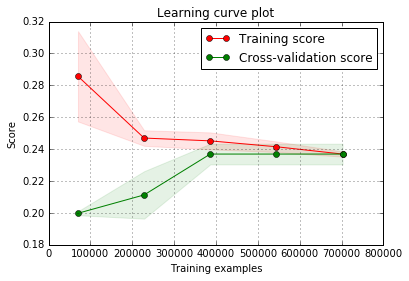

In [12]:
plot_learning_curve(model, "Learning curve plot", train_latter_X, train_y, cv=5)
plt.savefig('Learning_curve-PR2.png')

## Result
- 일단 그래프가 이쁩니다.